# Heart Disease UCI

Source: https://www.kaggle.com/ronitf/heart-disease-uci

Variables

1. age: The person's age in years
2. sex: The person's sex (1 = male, 0 = female)
3. cp: The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
4. trestbps: The person's resting blood pressure (mm Hg on admission to the hospital)
5. chol: The person's cholesterol measurement in mg/dl
6. fbs: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
7. restecg: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
8. thalach: The person's maximum heart rate achieved
9. exang: Exercise induced angina (1 = yes; 0 = no)
10. oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more here)
11. slope: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
12. ca: The number of major vessels (0-4)
13. thal: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
14. target: Heart disease (0 = no, 1 = yes)

In [1]:
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

## Load the data

In [2]:
data = pd.read_csv('./data/heart.csv')
# data.describe().T
data.describe().applymap(lambda x: f"{x:0.3f}").T

,count,mean,std,min,25%,50%,75%,max
age,303.000,54.366,9.082,29.000,47.500,55.000,61.000,77.000
sex,303.000,0.683,0.466,0.000,0.000,1.000,1.000,1.000
cp,303.000,0.967,1.032,0.000,0.000,1.000,2.000,3.000
trestbps,303.000,131.624,17.538,94.000,120.000,130.000,140.000,200.000
chol,303.000,246.264,51.831,126.000,211.000,240.000,274.500,564.000
fbs,303.000,0.149,0.356,0.000,0.000,0.000,0.000,1.000
restecg,303.000,0.528,0.526,0.000,0.000,1.000,1.000,2.000
thalach,303.000,149.647,22.905,71.000,133.500,153.000,166.000,202.000
exang,303.000,0.327,0.470,0.000,0.000,0.000,1.000,1.000
oldpeak,303.000,1.040,1.161,0.000,0.000,0.800,1.600,6.200


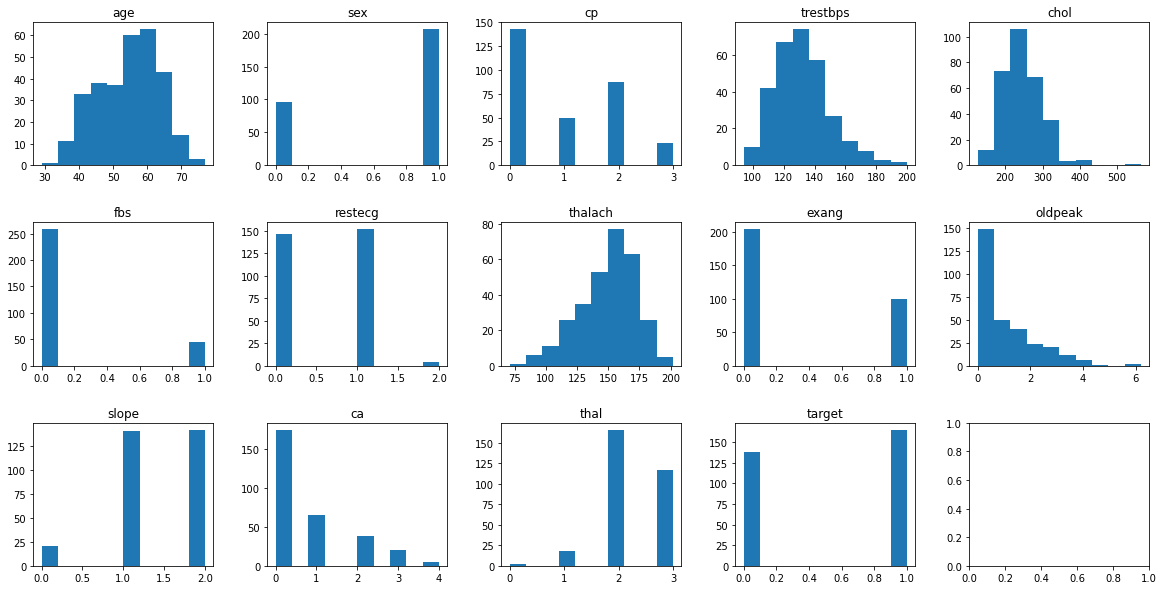

In [3]:
fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (20,10))
fig.subplots_adjust(hspace = 0.4, wspace = 0.3)
for i in range(data.shape[1]):
    ax = axes.flat[i]
    ax.hist(data.iloc[:,i])
    ax.set_title(data.columns[i])

## Pre-process the data

1. Check missing data - none
2. Drop the irrelevant predictors - unecessary in this case
3. Ensure data types are correct
3. Encode the categorical columns
4. Normalize the continuous columns
5. Put back the categorical and continuous columns together
6. Split the data into a training set and a validation set

In [4]:
# sometimes Python recognize int as str; also want to ensure the categorical data is int
data.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [5]:
# Categorical columns
cat_cols = ['cp', 'restecg', 'slope', 'thal']

# Option 1:  one-hot encode categorical variables
def onehot_encoding(data, cat_cols):
    df_cat   = []
    for col in cat_cols:
        df_cat.append(pd.get_dummies(data[col], prefix = col))
    df_cat   = pd.concat(df_cat, axis = 1)
    return df_cat
df_cat = onehot_encoding(data, cat_cols)
print(df_cat)

# Option 2: embedding
def embedding(data, cat_cols):
    cat_szs = [len(data[col].unique()) for col in cat_cols]
    emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
    selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
    embeddingz = []
    for i,e in enumerate(selfembeds):
        cat = torch.tensor(data[cat_cols[i]].values, dtype = torch.int64)
        embeddingz.append(e(cat))
    df_cat = torch.cat(embeddingz, 1)
    df_cat = pd.DataFrame(df_cat.detach().numpy(), index = data.index, 
                          columns = ['embeded_{}'.format(i) for i in range(df_cat.shape[1])])
    return df_cat, emb_szs

df_cat, emb_szs = embedding(data, cat_cols)
print(emb_szs, df_cat)

     cp_0  cp_1  cp_2  cp_3  restecg_0  restecg_1  restecg_2  slope_0  \
0       0     0     0     1          1          0          0        1   
1       0     0     1     0          0          1          0        1   
2       0     1     0     0          1          0          0        0   
3       0     1     0     0          0          1          0        0   
4       1     0     0     0          0          1          0        0   
..    ...   ...   ...   ...        ...        ...        ...      ...   
298     1     0     0     0          0          1          0        0   
299     0     0     0     1          0          1          0        0   
300     1     0     0     0          0          1          0        0   
301     1     0     0     0          0          1          0        0   
302     0     1     0     0          1          0          0        0   

     slope_1  slope_2  thal_0  thal_1  thal_2  thal_3  
0          0        0       0       1       0       0  
1          

In [6]:
# continuous columns
df_cont = data.drop(cat_cols + ['target'], axis = 1)
df_cont = (df_cont - df_cont.mean()) / df_cont.std()
print(df_cont)

          age       sex  trestbps      chol       fbs   thalach    exang  \
0    0.950624  0.679881  0.762694 -0.255910  2.390484  0.015417 -0.69548   
1   -1.912150  0.679881 -0.092585  0.072080 -0.416945  1.630774 -0.69548   
2   -1.471723 -1.465992 -0.092585 -0.815424 -0.416945  0.975900 -0.69548   
3    0.179877  0.679881 -0.662770 -0.198030 -0.416945  1.237849 -0.69548   
4    0.289984 -1.465992 -0.662770  2.078611 -0.416945  0.582975  1.43311   
..        ...       ...       ...       ...       ...       ...      ...   
298  0.289984 -1.465992  0.477601 -0.101562 -0.416945 -1.163356  1.43311   
299 -1.031296  0.679881 -1.232956  0.342190 -0.416945 -0.770432 -0.69548   
300  1.501157  0.679881  0.705675 -1.027653  2.390484 -0.377507 -0.69548   
301  0.289984  0.679881 -0.092585 -2.223854 -0.416945 -1.512623  1.43311   
302  0.289984 -1.465992 -0.092585 -0.198030 -0.416945  1.063216 -0.69548   

      oldpeak        ca  
0    1.085542 -0.713249  
1    2.119067 -0.713249  
2    0.31

In [7]:
# put back together the categorical and continuous columns
X_all = pd.concat([df_cont, df_cat], axis = 1).values
y_all = data['target'].values

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.2, random_state = 0)

# convert stuff to torch tensors so they can be used in PyTorch training
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
# y_train = F.one_hot(torch.LongTensor(y_train))  # not needed with Cross Entropy Loss
# y_test = F.one_hot(torch.LongTensor(y_test))
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
## for regression problem, should use
## y_train = torch.FloatTensor(y_train)
## y_test = torch.FloatTensor(y_test)

## Define the neural network architecture

In [4]:
class ANNModel(nn.Module):
    
    def __init__(self, in_size, out_size, hidden_sizes, p):
        super().__init__()

        layerlist = []
        for i in hidden_sizes:
            layerlist.append(nn.Linear(in_size,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            in_size = i
        layerlist.append(nn.Linear(hidden_sizes[-1], out_size))

        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x):
        x = self.layers(x)
        # this line is not necessary for regression, but is necessary for classification
        x = log_softmax(x, dim = 1) # Softmax does not directly work with loss functions in Pytorch
        return x

## Define other stuff needed to train the neural network model

In [9]:
torch.manual_seed(33)

# output size = 2, because the target has two classes
model = ANNModel(X_train.shape[1], 2, [5, 5, 3], p = 0.2)

# since this is a classification problem, use cross entropy loss
# for regression problem, use nn.MSELoss()
criterion = nn.CrossEntropyLoss()

# the optimizer to find weights
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# feed the data into the model by batches
batch_size = 100

# number of times to train the model
epochs = 300

# record the loss for each epoch
losses = []

## Train the model on training data

In [10]:
start_time = time.time()
for i in range(epochs):

    for j in range(0, X_train.shape[0], batch_size):
        # make a prediction
        y_pred = model(X_train[j:min(j+batch_size, X_train.shape[0]), :])

        # calculate the loss and record it
        loss = criterion(y_pred, y_train[j:min(j+batch_size, X_train.shape[0])])
        if j == (X_train.shape[0] - np.mod(X_train.shape[0], batch_size)):
            losses.append(loss.detach().numpy())
        # a neat trick to save screen space:
        if (i%(int(epochs/10)) == 1) and (j == 0):
            print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

        # set the gradients to zero
        optimizer.zero_grad()

        # calculate the gradients
        loss.backward()

        # let the optimizer update the weights
        optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.81151843
epoch:  31  loss: 0.63638967
epoch:  61  loss: 0.58746541
epoch:  91  loss: 0.48823074
epoch: 121  loss: 0.44434196
epoch: 151  loss: 0.42173150
epoch: 181  loss: 0.43055645
epoch: 211  loss: 0.35969722
epoch: 241  loss: 0.40683484
epoch: 271  loss: 0.37951180
epoch: 299  loss: 0.25601944

Duration: 3 seconds


Text(0.5, 0, 'epoch')

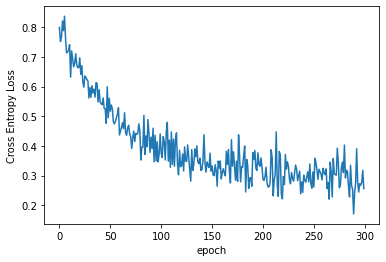

In [11]:
plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch')

## Evaluate the model on the test set

In [12]:
# make sure to run model.eval(), or the random dropout will still be active
model.eval()
with torch.no_grad():
    y_val = model(X_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.43732637


In [13]:
rows = 50
correct = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test[i]:^7}')
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([-0.0723, -2.6629])    0      0   
tensor([-1.9756, -0.1493])    1      1   
tensor([-1.6635, -0.2101])    1      0   
tensor([-0.0633, -2.7916])    0      0   
tensor([-0.0791, -2.5762])    0      1   
tensor([-0.1393, -2.0402])    0      0   
tensor([-0.0635, -2.7884])    0      0   
tensor([-0.0757, -2.6187])    0      0   
tensor([-0.0627, -2.8002])    0      0   
tensor([-0.0553, -2.9227])    0      0   
tensor([-2.9520, -0.0536])    1      1   
tensor([-2.7053, -0.0692])    1      1   
tensor([-0.0709, -2.6815])    0      0   
tensor([-1.9692, -0.1503])    1      1   
tensor([-4.3387, -0.0131])    1      1   
tensor([-1.4582, -0.2648])    1      1   
tensor([-0.0722, -2.6647])    0      1   
tensor([-3.4215, -0.0332])    1      1   
tensor([-0.0592, -2.8568])    0      0   
tensor([-2.7734, -0.0645])    1      1   
tensor([-2.6396, -0.0741])    1      1   
tensor([-0.1111, -2.2524])    0      0   
tensor([-0.0723, -2.6631])    0   

## Save and re-load the model

In [14]:
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'HeartClassModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

# To load the model
model2 = ANNModel(X_train.shape[1], 2, [5, 5, 3], p = 0.2)
model2.load_state_dict(torch.load('HeartClassModel.pt'))
model2.eval() # make sure to run this step!

# To make new predictions
with torch.no_grad():
    y_val = model2(X_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.43732637
